# 第 6 章 逻辑斯蒂回归与最大熵模型

条件概率分布表示的分类模型, 逻辑斯谛回归模型可以用于二类或多类分类。
$$P(Y=k | x)=\frac{\exp \left(w_{k} \cdot x\right)}{1+\sum_{k=1}^{K-1} \exp \left(w_{k} \cdot x\right)}, \quad k=1,2, \cdots, K-1$$
$$P(Y=K | x)=\frac{1}{1+\sum_{k=1}^{K-1} \exp \left(w_{k} \cdot x\right)}$$
这里，$x$为输入特征，$w$为特征的权值。

最大熵模型是由以下条件概率分布表示的分类模型, 最大熵模型也可以用于二类或多类分类。
$$P_{w}(y | x)=\frac{1}{Z_{w}(x)} \exp \left(\sum_{i=1}^{n} w_{i} f_{i}(x, y)\right)$$
$$Z_{w}(x)=\sum_{y} \exp \left(\sum_{i=1}^{n} w_{i} f_{i}(x, y)\right)$$
其中，$Z_w(x)$是规范化因子，$f_i$为特征函数，$w_i$为特征的权值。

最大熵原理认为在所有可能的概率模型（分布）的集合中，熵最大的模型是最好的模型。
$$\min -H(P)=\sum_{x, y} \tilde{P}(x) P(y | x) \log P(y | x)$$
$$s.t.  \quad P\left(f_{i}\right)-\tilde{P}\left(f_{i}\right)=0, \quad i=1,2, \cdots, n$$
$$\sum_{y} P(y | x)=1$$
求解此最优化问题的对偶问题得到最大熵模型。

In [1]:
from math import exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [6]:
# processing data for model.
def create_data():
  iris = load_iris()
  df = pd.DataFrame(iris.data, columns=iris.feature_names)
  df['label'] = iris.target
  df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
  data = np.array(df.iloc[:100, [0,1,-1]])
  return data[:,:2], data[:,-1]

# loadding data
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("The shape of train data: X-{}, y-{}".format(X_train.shape, y_train.shape))
print("The shape of test data: X-{}, y-{}".format(X_test.shape, y_test.shape))

The shape of train data: X-(70, 2), y-(70,)
The shape of test data: X-(30, 2), y-(30,)


LogisticRegression Model(learning_rate=0.01, max_iter=200)
The accuracy of logistic regression model: 0.03333333333333333
-----------------------------------------------------------------


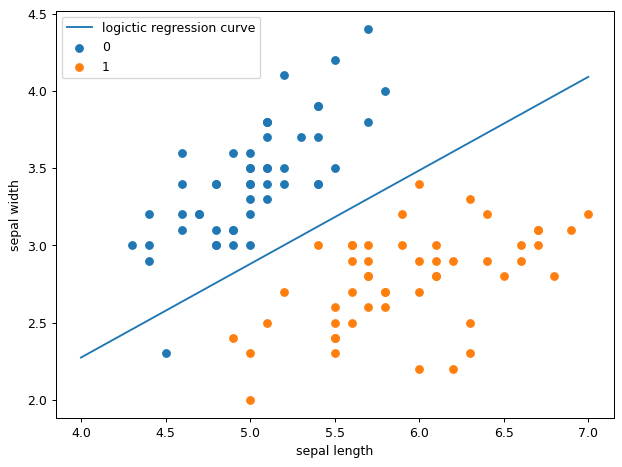

In [25]:
# the class of logistic regression algorithm.
class LogisticRegressionClassifier:
  def __init__(self, max_iter=200, learning_rate=0.01):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    
  def sigmoid(self, x):
    return 1 / (1 + exp(-x))
  
  def data_matrix(self, X):
    data_mat = []
    for d in X:
      data_mat.append([1.0, *d])
    return data_mat
  
  def fit(self, X, y):
    data_mat = self.data_matrix(X)
    self.weights = np.zeros((len(data_mat[0]), 1), dtype=np.float32)
    for iter_ in range(self.max_iter):
      for i in range(len(X)):
        result = self.sigmoid(np.dot(data_mat[i], self.weights))
        error = y[i] - result
        self.weights += self.learning_rate * error * np.transpose([data_mat[i]])
    print("LogisticRegression Model(learning_rate={}, max_iter={})".format(self.learning_rate, self.max_iter))
        
  def accuracy(self, X_test, y_test):
    num_correct = 0
    X_test = self.data_matrix(X_test)
    for x, y in zip(X_test, y_test):
      result = np.dot(x, self.weights)
      if (result > 0 and y == 1) or (result < 0 and y == 0):
        num_correct += 1
      return num_correct / len(X_test)

# ------------------------------------------------
# TEST
logistic_regression_model = LogisticRegressionClassifier()
logistic_regression_model.fit(X_train, y_train)
print("The accuracy of logistic regression model: {}".format(logistic_regression_model.accuracy(X_test, y_test)))
print("-----------------------------------------------------------------")

# vistualation
x_ponits = np.arange(4, 8)
y_ = -(logistic_regression_model.weights[1]*x_ponits + logistic_regression_model.weights[0]) / logistic_regression_model.weights[2]
fig = plt.figure(figsize = (8,6), dpi = 90)
plt.plot(x_ponits, y_, label='logictic regression curve')
plt.scatter(X[:50,0],X[:50,1], label='0')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

## scikit-learn instance
### sklearn.linear_model.LogisticRegression
[sklearn site](https://scikit-learn.org/stable/)

LogisticRegression(max_iter=200)
1.0
[[ 2.70546517 -2.72450507]] [-5.98476364]
-----------------------------------------------------------------


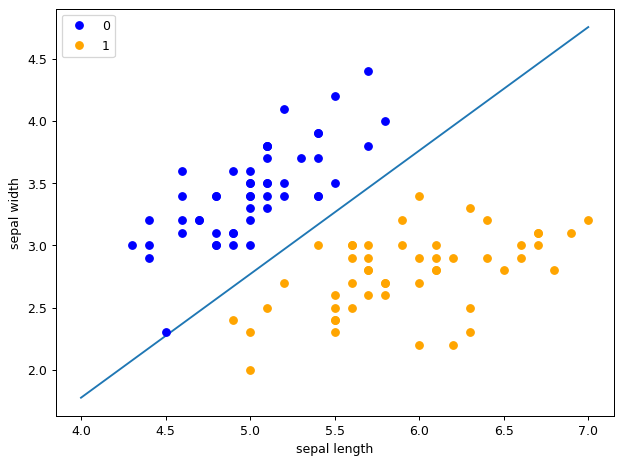

In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=200)
print(clf.fit(X_train, y_train))
print(clf.score(X_test, y_test))
print(clf.coef_, clf.intercept_)
print("-----------------------------------------------------------------")

x_ponits = np.arange(4, 8)
y_ = -(clf.coef_[0][0]*x_ponits + clf.intercept_)/clf.coef_[0][1]
fig = plt.figure(figsize = (8,6), dpi = 90)
plt.plot(x_ponits, y_)
plt.plot(X[:50, 0], X[:50, 1], 'bo', color='blue', label='0')
plt.plot(X[50:, 0], X[50:, 1], 'bo', color='orange', label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

## 最大熵

In [39]:
import math
from copy import deepcopy

# the class of maximum entropy.
class MaximumEntropy:
  def __init__(self, EPS=0.005):
    self._samples = []
    self._Y = set()  # set of labels, 相当于去重后的 y
    self._numXY = {}
    self._N = 0  # 样本数
    self._Ep_ = []  # 样本分布的特征期望
    self._xyID = {}  # key 记录 (x,y), value 记录 id number
    self._n = 0  # 特征键值 (x, y) 的个数
    self._C = 0  # 最大特征数
    self._IDxy = {}  # key-->(x, y), value-->id number
    self._w = []
    self._EPS = EPS  # 收敛条件
    self._lastw = [] # 上一次 w 参数值
  
  def loadData(self, dataset):
    self._samples = deepcopy(dataset)
    for items in self._samples:
      y = items[0]
      X = items[1:]
      self._Y.add(y)  # 集合的互斥性质
      for x in X:
        if (x, y) in self._numXY:
          self._numXY[(x, y)] += 1
        else:
          self._numXY[(x, y)] = 1
    
    self._N = len(self._samples)
    self._n = len(self._numXY)
    self._C = max(len(sample) - 1 for sample in self._samples)
    self._w = [0] * self._n
    self._lastw = self._w[:]
    
    self._Ep_ = [0] * self._n
    for i, xy in enumerate(self._numXY):
      self._Ep_[i] = self._numXY[xy] / self._N
      self._xyID[xy] = i
      self._IDxy[i] = xy
  
  # compute each Z(x) value.
  def _Zx(self, X):
    zx = 0
    for y in self._Y:
      ss = 0
      for x in X:
        if (x, y) in self._numXY:
          ss += self._w[self._xyID[(x, y)]]
      zx += math.exp(ss)
    return zx
  
   # 计算每个P(y|x) 
  def _model_pyx(self, y, X):
    zx = self._Zx(X)
    ss = 0
    for x in X:
      if (x, y) in self._numXY:
        ss += self._w[self._xyID[(x, y)]]
    pyx = math.exp(ss) / zx
    return pyx
  
  # 计算特征函数 fi 关于模型的期望
  def _model_ep(self, index):
    x, y = self._IDxy[index]
    ep = 0
    for sample in self._samples:
      if x not in sample:
        continue
      pyx = self._model_pyx(y, sample)
      ep += pyx / self._N
    return ep
  
  # 判断是否全部收敛
  def _convergence(self):
    for last, now in zip(self._lastw, self._w):
      if abs(last - now) >= self._EPS:
        return False
    return True
  
  # 计算预测概率
  def predict(self, X):
    Z = self._Zx(X)
    result = {}
    for y in self._Y:
      ss = 0
      for x in X:
        if (x, y) in self._numXY:
          ss += self._w[self._xyID[(x, y)]]
      pyx = math.exp(ss) / Z
      result[y] = pyx
    return result
  
  # 训练数据
  def train(self, maxiter=12):
    # 最大训练次数
    for loop in range(maxiter):
      print("iter:%d ---------------------->" % loop)
      self._lastw = self._w[:]
      for i in range(self._n):
        ep = self._model_ep(i)  # 计算第i个特征的模型期望
        self._w[i] += math.log(self._Ep_[i] / ep) / self._C  # 更新参数
      print("w:", self._w)
      if self._convergence():  # 判断是否收敛
        break

# --------------------------------------------------
# TEST
dataset = [['no', 'sunny', 'hot', 'high', 'FALSE'],
           ['no', 'sunny', 'hot', 'high', 'TRUE'],
           ['yes', 'overcast', 'hot', 'high', 'FALSE'],
           ['yes', 'rainy', 'mild', 'high', 'FALSE'],
           ['yes', 'rainy', 'cool', 'normal', 'FALSE'],
           ['no', 'rainy', 'cool', 'normal', 'TRUE'],
           ['yes', 'overcast', 'cool', 'normal', 'TRUE'],
           ['no', 'sunny', 'mild', 'high', 'FALSE'],
           ['yes', 'sunny', 'cool', 'normal', 'FALSE'],
           ['yes', 'rainy', 'mild', 'normal', 'FALSE'],
           ['yes', 'sunny', 'mild', 'normal', 'TRUE'],
           ['yes', 'overcast', 'mild', 'high', 'TRUE'],
           ['yes', 'overcast', 'hot', 'normal', 'FALSE'],
           ['no', 'rainy', 'mild', 'high', 'TRUE']]

max_entropy = MaximumEntropy()
print(max_entropy._Y)
x = ['overcast', 'mild', 'high', 'FALSE']
max_entropy.loadData(dataset)
max_entropy.train()
print("------------------------------------------------------------------------------------------")
print('The maximum entropy predict:', max_entropy.predict(x))

set()
iter:0 ---------------------->
w: [0.0455803891984887, -0.002832177999673058, 0.031103560672370825, -0.1772024616282862, -0.0037548445453157455, 0.16394435955437575, -0.02051493923938058, -0.049675901430111545, 0.08288783767234777, 0.030474400362443962, 0.05913652210443954, 0.08028783103573349, 0.1047516055195683, -0.017733409097415182, -0.12279936099838235, -0.2525211841208849, -0.033080678592754015, -0.06511302013721994, -0.08720030253991244]
iter:1 ---------------------->
w: [0.11525071899801315, 0.019484939219927316, 0.07502777039579785, -0.29094979172869884, 0.023544184009850026, 0.2833018051925922, -0.04928887087664562, -0.101950931659509, 0.12655289130431963, 0.016078718904129236, 0.09710585487843026, 0.10327329399123442, 0.16183727320804359, 0.013224083490515591, -0.17018583153306513, -0.44038644519804815, -0.07026660158873668, -0.11606564516054546, -0.1711390483931799]
iter:2 ---------------------->
w: [0.18178907332733973, 0.04233703122822168, 0.11301330241050131, -0.37

## 习题 6.2

迭代次数：3232次
最终梯度：[ 0.00144779  0.00046133  0.00490279 -0.00999848]
最终权重：[  2.96908597   1.60115396   5.04477438 -13.43744079]


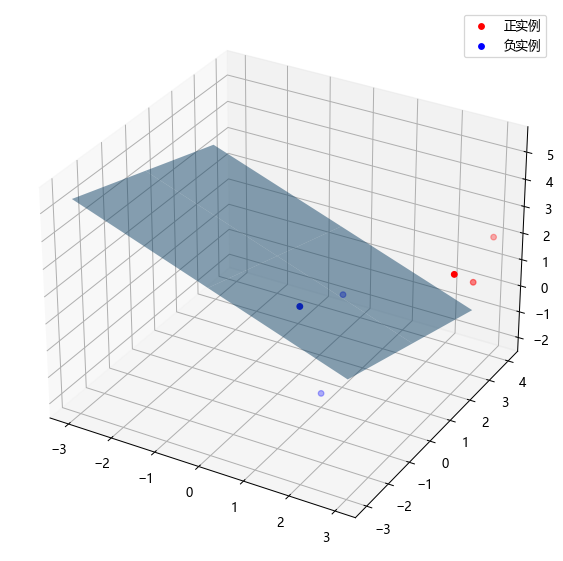

In [44]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import mpl

# 图像显示中文
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']

class LogisticRegression:
    def __init__(self, learn_rate=0.1, max_iter=5000, tol=1e-2):
        self.learn_rate = learn_rate  # 学习率
        self.max_iter = max_iter  # 迭代次数
        self.tol = tol  # 迭代停止阈值
        self.w = None  # 权重

    def preprocessing(self, X):
        """将原始X末尾加上一列，该列数值全部为1"""
        row = X.shape[0]
        y = np.ones(row).reshape(row, 1)
        X_prepro = np.hstack((X, y))
        return X_prepro

    def sigmod(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X_train, y_train):
        X = self.preprocessing(X_train)
        y = y_train.T
        # 初始化权重w
        self.w = np.array([[0] * X.shape[1]], dtype=np.float64)
        k = 0
        for loop in range(self.max_iter):
            # 计算梯度
            z = np.dot(X, self.w.T)
            grad = X * (y - self.sigmod(z))
            grad = grad.sum(axis=0)
            # 利用梯度的绝对值作为迭代中止的条件
            if (np.abs(grad) <= self.tol).all():
                break
            else:
                # 更新权重w 梯度上升——求极大值
                self.w += self.learn_rate * grad
                k += 1
        print("迭代次数：{}次".format(k))
        print("最终梯度：{}".format(grad))
        print("最终权重：{}".format(self.w[0]))

    def predict(self, x):
        p = self.sigmod(np.dot(self.preprocessing(x), self.w.T))
        print("Y=1的概率被估计为：{:.2%}".format(p[0][0]))  # 调用score时，注释掉
        p[np.where(p > 0.5)] = 1
        p[np.where(p < 0.5)] = 0
        return p

    def score(self, X, y):
        y_c = self.predict(X)
        error_rate = np.sum(np.abs(y_c - y.T)) / y_c.shape[0]
        return 1 - error_rate

    def draw(self, X, y):
        # 分离正负实例点
        y = y[0]
        X_po = X[np.where(y == 1)]
        X_ne = X[np.where(y == 0)]
        # 绘制数据集散点图
        fig = plt.figure(figsize = (10,8), dpi = 90)
        ax = plt.axes(projection='3d')
        x_1 = X_po[0, :]
        y_1 = X_po[1, :]
        z_1 = X_po[2, :]
        x_2 = X_ne[0, :]
        y_2 = X_ne[1, :]
        z_2 = X_ne[2, :]
        ax.scatter(x_1, y_1, z_1, c="r", label="正实例")
        ax.scatter(x_2, y_2, z_2, c="b", label="负实例")
        ax.legend(loc='best')
        # 绘制p=0.5的区分平面
        x = np.linspace(-3, 3, 3)
        y = np.linspace(-3, 3, 3)
        x_3, y_3 = np.meshgrid(x, y)
        a, b, c, d = self.w[0]
        z_3 = -(a * x_3 + b * y_3 + d) / c
        ax.plot_surface(x_3, y_3, z_3, alpha=0.5)  # 调节透明度
        plt.show()
        
# -------------------------------------------
# TEST
X_train = np.array([[3, 3, 3], [4, 3, 2], [2, 1, 2],
                    [1, 1, 1], [-1, 0, 1], [2, -2, 1]])
y_train = np.array([[1, 1, 1, 0, 0, 0]])
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.draw(X_train, y_train)